In [4]:
from __future__ import division
from glob import glob
import tensorflow as tf
from tensorflow import keras
import random
import nrrd
import numpy as np

import helper_funcs
from data_gen import CTA
from tensorflow.python.client import device_lib
from Networks import model_unet_2
from helper_funcs import dice_coef_loss

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

training_dir = "./training_data/train_cyl_grey_im/"
label_dir = "./training_data/train_cyl_grey_la/"
data_list =glob('{}/*.nrrd'.format(training_dir))
label_list=glob('{}/*.nrrd'.format(label_dir))

policy = keras.mixed_precision.Policy('mixed_float16')
keras.mixed_precision.set_global_policy(policy)

keras.backend.clear_session()

img_size = (512, 512, 40)
model = model_unet_2.get_model(img_size)
a=model.summary(line_length=150)



Num GPUs Available:  1
(None, 512, 512, 40, 1)
Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 512, 512, 40, 1)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d (Conv3D)                                  (None, 512, 512, 40, 16)         448               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
batch_normalization (BatchNormal

In [7]:
val_samples = int(np.floor(len(data_list)*0.2))
random.Random(7331).shuffle(data_list)
random.Random(7331).shuffle(label_list)

train_img_paths = data_list[:-val_samples]
train_lab_paths = label_list[:-val_samples]

val_img_paths = data_list[-val_samples:]
val_lab_paths = label_list[-val_samples:]

train_gen = CTA(train_img_paths, train_lab_paths,1)
valid_gen = CTA(val_img_paths, val_lab_paths,1)

In [8]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [9]:
import time

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.01), loss=[dice_coef_loss], metrics=[tf.keras.losses.BinaryCrossentropy()])
epochs = 200

class BatchHistories(keras.callbacks.Callback):

    def on_train_begin(self,logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
batch_loss = BatchHistories()

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, verbose=1),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint("unet2_toy_train_z40_grey.h5", verbose=1, save_best_only=True),
    batch_loss
]
start = time.time()
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=callbacks,shuffle=True)
end = time.time()
print('Training time: ', end-start)

Epoch 1/200
806/806 [==============================] - 1018s 1s/step - loss: 0.0517 - binary_crossentropy: 0.3114 - val_loss: 0.0180 - val_binary_crossentropy: 0.1759

Epoch 00001: val_loss improved from inf to 0.01799, saving model to unet2_toy_train_z40_grey.h5
Epoch 2/200
806/806 [==============================] - 929s 1s/step - loss: 0.0087 - binary_crossentropy: 0.0989 - val_loss: 0.0015 - val_binary_crossentropy: 0.0380

Epoch 00002: val_loss improved from 0.01799 to 0.00148, saving model to unet2_toy_train_z40_grey.h5
Epoch 3/200
806/806 [==============================] - 926s 1s/step - loss: 8.8603e-04 - binary_crossentropy: 0.0286 - val_loss: 6.1031e-04 - val_binary_crossentropy: 0.0236

Epoch 00003: val_loss improved from 0.00148 to 0.00061, saving model to unet2_toy_train_z40_grey.h5
Epoch 4/200
806/806 [==============================] - 917s 1s/step - loss: 4.5929e-04 - binary_crossentropy: 0.0201 - val_loss: 3.6143e-04 - val_binary_crossentropy: 0.0177

Epoch 00004: val_lo

In [7]:
model.save('Model_pretrained_cyl_z40_new')
model.save('Model_pretrained_cyl_z40_new.h5')

INFO:tensorflow:Assets written to: Model_pretrained_cyl_z40_new\assets


Text(0, 0.5, 'Dice loss')

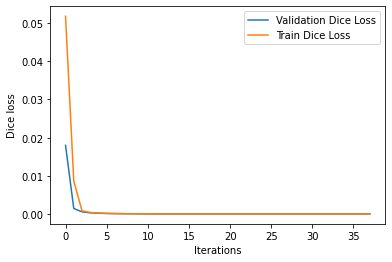

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['val_loss'], label='Validation Dice Loss')
plt.plot(history.history['loss'], label='Train Dice Loss')
#plt.plot(batch_loss.losses)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Dice loss')

In [13]:
training_dir = "./training_data/train_patch_z40_dnep_im"
label_dir = "./training_data/train_patch_z40_dnep_la"
data_list =glob('{}/*.nrrd'.format(training_dir))
label_list=glob('{}/*.nrrd'.format(label_dir))
val_samples = int(np.floor(len(data_list)*0.2))
random.Random(7331).shuffle(data_list)
random.Random(7331).shuffle(label_list)

train_img_paths = data_list[:-val_samples]
train_lab_paths = label_list[:-val_samples]

val_img_paths = data_list[-val_samples:]
val_lab_paths = label_list[-val_samples:]

train_gen = TOY(train_img_paths, train_lab_paths,1)
valid_gen = TOY(val_img_paths, val_lab_paths,1)

In [34]:
model_pret = keras.models.load_model('unet2_toy_train_z40_grey.h5', compile=False)
#for layer in model_pret.layers[:23]:
	#layer.trainable = False
model_pret.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.01), loss=[dice_coef_loss], metrics=[tf.keras.losses.BinaryCrossentropy()])
epochs = 200

In [35]:


class BatchHistories(keras.callbacks.Callback):

    def on_train_begin(self,logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
batch_loss_fine = BatchHistories()

callbacks = [
    keras.callbacks.EarlyStopping(patience=20, verbose=1),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00000001, verbose=1),
    keras.callbacks.ModelCheckpoint("unet2_train_z40_grey_normal_lr.h5", verbose=1, save_best_only=True),
    batch_loss_fine
]
start = time.time()
history_fine = model_pret.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=callbacks,shuffle=True)
end = time.time()
print('Training time: ', end-start)

Epoch 1/200
372/372 [==============================] - 414s 1s/step - loss: 0.0025 - binary_crossentropy: 0.0313 - val_loss: 0.0019 - val_binary_crossentropy: 0.0267

Epoch 00001: val_loss improved from inf to 0.00195, saving model to unet2_train_z40_grey_normal_lr.h5
Epoch 2/200
372/372 [==============================] - 388s 1s/step - loss: 0.0020 - binary_crossentropy: 0.0272 - val_loss: 0.0019 - val_binary_crossentropy: 0.0249

Epoch 00002: val_loss improved from 0.00195 to 0.00186, saving model to unet2_train_z40_grey_normal_lr.h5
Epoch 3/200
372/372 [==============================] - 386s 1s/step - loss: 0.0019 - binary_crossentropy: 0.0254 - val_loss: 0.0018 - val_binary_crossentropy: 0.0237

Epoch 00003: val_loss improved from 0.00186 to 0.00182, saving model to unet2_train_z40_grey_normal_lr.h5
Epoch 4/200
372/372 [==============================] - 388s 1s/step - loss: 0.0019 - binary_crossentropy: 0.0242 - val_loss: 0.0018 - val_binary_crossentropy: 0.0226

Epoch 00004: val_l

In [31]:
model_fertig = keras.models.load_model('unet2_toy_train_z40_grey.h5', compile=False)

In [3]:
#import ndpatch
#model = keras.models.load_model('unet2_z32_bs1_ol0_good.h5', compile=False)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070, compute capability 7.5


In [17]:
import skimage

In [18]:
import patchify
def z_padding(input):
    if input.shape[:2] == (512,512):
        pass
    else:
        input=input[:512,:512,:]
    z_size = 40-input.shape[2]%40
    pad = np.zeros(input.shape[0:2]+ (z_size,))
    return np.append(input, pad, axis=-1)

In [20]:
import ndpatch
from scipy import ndimage
test_img, header = nrrd.read('./test_data/R3.nrrd')
im_deno = ndimage.median_filter(test_img, size=2)
img_ad_eq = skimage.exposure.equalize_adapthist(im_deno, clip_limit=0.03)


image_norm = (img_ad_eq - np.min(img_ad_eq))/(np.max(img_ad_eq)-np.min(img_ad_eq))
patch_shape =(512, 512, 40)
image_pad = z_padding(image_norm)
test_patches=patchify.patchify(image_pad, (512,512,40), step=40)
pat_size = test_patches.shape
test_patches = test_patches.squeeze()
test_patches = np.expand_dims(test_patches, -1)
pred_patches = np.empty(shape=test_patches.shape)
print(test_patches.shape)
for i in np.arange(test_patches.shape[0]):
    pred = model_pret.predict(np.expand_dims(test_patches[i,:,:,:,0],axis=0),batch_size=1, verbose=1)
    pred = (pred > 0.05).astype(np.uint8)
    pred = np.squeeze(pred)
    pred_patches[i,:,:,:,0] =  pred
#
#predictions = model.predict(test_patches)

(29, 512, 512, 40, 1)
1/1 [==============================] - 0s 42ms/step


In [21]:
pred_patches=pred_patches.squeeze()
pred_patches = np.expand_dims(np.expand_dims(pred_patches, axis=0),axis=0)
print(pred_patches.shape)


(1, 1, 29, 512, 512, 40)


In [22]:
reconstructed = patchify.unpatchify(pred_patches,image_pad.shape)

In [23]:
print(np.max(reconstructed))

1.0


In [24]:
from scipy import ndimage
recon_opened = ndimage.binary_opening(reconstructed, iterations=5).astype(int)
recon_closed = ndimage.binary_closing(reconstructed, iterations=10).astype(int)
recon_co = ndimage.binary_opening(recon_closed, iterations=5).astype(int)
recon_oc = ndimage.binary_closing(recon_closed, iterations=10).astype(int)

In [25]:
def skull_id(labels_out):
	labels_out=labels_out.reshape((1,-1))
	labels_out=labels_out[0,:]
	label=np.unique(labels_out)
	hist, bin_edges=np.histogram(labels_out,bins=label)
	hist=np.ndarray.tolist(hist)
	hist_=hist
	hist_=np.array(hist_)
	hist.sort(reverse = True)
	idx=(hist_==hist[1])
	idx=idx+1-1
	idx_=np.sum(idx*label[0:len(idx)])
	print('idx',idx_)
	return idx_

In [26]:
import cc3d
import nrrd
import numpy as np
labels_out, N = cc3d.connected_components(recon_oc, return_N=True)

In [27]:
aorta_label = skull_id(labels_out)

idx 143


In [28]:
labels_big = labels_out * (labels_out == aorta_label)

In [19]:
#labels_big_op = ndimage.binary_opening(labels_big, iterations=2).astype(int)

In [29]:
nrrd.write('R3_pred_z40_cc_t005_pretrained.seg.nrrd', labels_big)

In [30]:
nrrd.write('R3_oc_pred_z40_cc_t005_pretrained.seg.nrrd', recon_oc)
nrrd.write('R3_co_pred_z40_cc_t005_pretrained.seg.nrrd', recon_co)
nrrd.write('R3_re_pred_z40_cc_t005_pretrained.seg.nrrd', reconstructed)

In [14]:
print(np.max(reconstructed))

1.0


In [16]:
def predict(test_dir, model):
    test_list=glob('{}/*.nrrd'.format(test_dir))
    image_list = []
    i=0
    for im in test_list:
        ima, header = nrrd.read(test_list[i])
        image_list.append(ima)
    image_list = np.array(image_list)
    predictions =  model.predict(image_list)
    return predictions

In [12]:
pred = predict('toy_test', model)
pred = np.squeeze(pred)
#np.squeeze(pred)
pred = (pred > 0.2).astype(np.uint8)

In [13]:
print(np.max(pred))

1


In [14]:

filename = 'toy_test_97' + '.seg.nrrd'
nrrd.write(filename, pred)

In [41]:

#print(test_list)
test_img1, hered = nrrd.read(test_list[0])
a,b,c=test_img1.shape
test_img1 = resizing(test_img1)
test_img_1=np.expand_dims(test_img1,axis=3)
test_img_1=np.expand_dims(test_img_1,axis=0)
print(test_img_1.shape)
print(a,b,c)

NameError: name 'test_list' is not defined

In [44]:
test_pred1 = model.predict(test_img_1)
pred_R1 = (test_pred1 > 0.2).astype(np.uint8)
print(pred_R1.shape)
pred=np.squeeze(pred_R1,axis=0)
pred=np.squeeze(pred,axis=-1)

(1, 256, 256, 128, 1)


In [3]:
import time
import skimage
import numpy as np
from scipy import ndimage
import nrrd
import SimpleITK as sitk
start = time.time()
test, h = nrrd.read('./test/R1.nrrd')
test = skimage.exposure.equalize_adapthist(test, clip_limit=0.03)
test = ndimage.median_filter(test, size=2)

print('min: ', np.min(test), 'max:', np.max(test))
#test_vessel = skimage.filters.frangi(test)
test_norm = (test - np.min(test))/(np.max(test)-np.min(test))
print(np.max(test_norm))
nrrd.write('test_denoised.nrrd', test_norm)
end = time.time()
print('Pre-processing time: ', end-start)

min:  0.00042735042735042735 max: 0.9999389499389499
1.0
Pre-processing time:  142.01910758018494


In [5]:
sigma_est = skimage.restoration.estimate_sigma(test)
print(sigma_est)

13.136792404745481


In [4]:
test_denoised = ndimage.median_filter(test, size=2)

1.0


(array([5.9341408e+07, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e

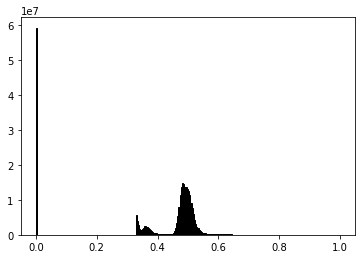

In [20]:
plt.hist(test_norm.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')

(array([59341408.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0

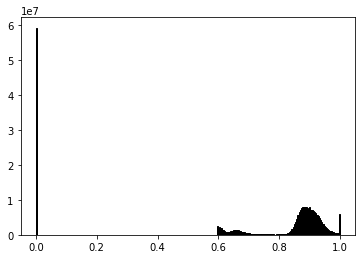

In [23]:
import skimage
p2, p98 = np.percentile(test_norm, (2, 98))
img_contrast_streched = skimage.exposure.rescale_intensity(test_norm, in_range=(p2, p98))
plt.hist(img_contrast_streched.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')

In [25]:
nrrd.write('test_contrast_streched.nrrd', img_contrast_streched)

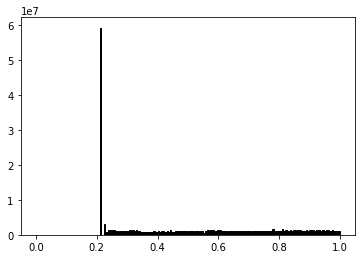

In [28]:
img_eq = skimage.exposure.equalize_hist(test_norm)
plt.hist(img_eq.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
nrrd.write('test_equalized.nrrd', img_eq)

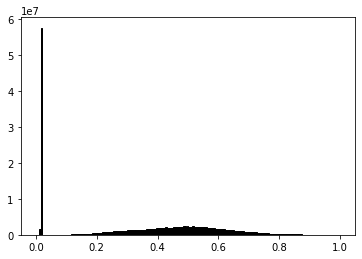

In [30]:
img_ad_eq = skimage.exposure.equalize_adapthist(test_norm, clip_limit=0.03)
plt.hist(img_ad_eq.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
nrrd.write('test_ad_equalized.nrrd', img_ad_eq)

In [25]:
r1, h = nrrd.read('./Rider/Rider/R1 (AD)/R1.seg.nrrd')

In [26]:
nrrd.write('R1_label.nrrd',r1)

In [27]:
from scipy import spatial

In [85]:
r1_label_orig, h = nrrd.read('./Rider/Rider/R3/R3.seg.nrrd')
r1_label_orig = z_padding(r1_label_orig).astype('uint32')
r1_label_test, h =nrrd.read('./labels_big.seg.nrrd')
dice_score = 1 - helper_funcs.dice_loss(r1_label_orig, r1_label_test)
print('Dice score: ', dice_score)

InvalidArgumentError: required broadcastable shapes [Op:Mul]

In [37]:
print(r1_label_orig.dtype)

uint32


In [86]:
nrrd.write('R1_label_orig.seg.nrrd',r1_label_orig)
nrrd.write('R1_label_test.seg.nrrd',r1_label_test)